In [1]:
!pip install -q 'tensorflow-text==2.11.*'
!pip install -q tensorflow_datasets
!pip install -q einops
!pip install rouge-score


ERROR: Could not find a version that satisfies the requirement tensorflow-text==2.11.* (from versions: 2.12.0rc0, 2.12.0, 2.12.1, 2.13.0rc0, 2.14.0rc0, 2.14.0, 2.15.0rc0, 2.15.0, 2.16.0rc0, 2.16.1, 2.17.0rc0, 2.17.0, 2.18.0rc0, 2.18.0, 2.18.1)
ERROR: No matching distribution found for tensorflow-text==2.11.*


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_datasets as tfds

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
def get_data(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

def get_dataset(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')
    captions = (path/'/content/flickr8k/Flickr8k_text.zip/Flickr8k.token.txt').read_text().splitlines()
    captions = [cap.split('\t') for cap in captions]
    captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)

    train_imgs_path = (path/'/content/flickr8k/Flickr8k_text.zip/Flickr_8k.trainImages.txt').read_text().splitlines()
    test_imgs_path = (path/'/content/flickr8k/Flickr8k_text.zip/Flickr_8k.testImages.txt').read_text().splitlines()

    train_caps = [(str(path/'/content/flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in train_imgs_path]
    test_caps = [(str(path/'/content/flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in test_imgs_path]

    train_raw = tf.data.experimental.from_list(train_caps)
    test_raw = tf.data.experimental.from_list(test_caps)

    return train_raw, test_raw

In [5]:
get_data()
train_raw, test_raw = get_dataset()

1115419746/1115419746 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
2340801/2340801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
print(len(train_raw), len(test_raw))
print(train_raw.element_spec)

for img_path, captions in train_raw.take(1):
    break

print(img_path)
print(captions)

6000 1000
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))
tf.Tensor(b'/content/flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [7]:
image_shape = (224, 224, 3)
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Input
import tensorflow as tf

image_shape = (224, 224, 3)  # Example shape, modify if needed

# Define the feature extractor without the invalid argument
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input

# Use EfficientNet instead of ResNet for better feature extraction
feature_extractor = EfficientNetB2(
    input_shape=image_shape,
    include_top=False,
    weights="imagenet"
)
feature_extractor.trainable = False  # Keep frozen initially
# Apply preprocessing separately
def preprocess_images(images):
    return preprocess_input(images)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

In [9]:
img = load_img(img_path.numpy().decode('utf-8'))
print(img.shape)
print(feature_extractor(img[tf.newaxis, ...]).shape)

(224, 224, 3)
(1, 7, 7, 1408)


In [10]:
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.join(['[START]',text,'[END]'], separator = ' ')
    return text

In [11]:
standardize('A black dog is running after a white dog in the snow .')

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] a black dog is running after a white dog in the snow  [END]'>

In [12]:
vocab_size = 5000
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                               standardize = standardize,
                                               ragged = True)

vectorizer.adapt(train_raw.map(lambda img_path, cap: cap).unbatch().batch(1024))

In [13]:
print(vectorizer.get_vocabulary()[:10])

['', '[UNK]', np.str_('a'), np.str_('[START]'), np.str_('[END]'), np.str_('in'), np.str_('the'), np.str_('on'), np.str_('is'), np.str_('and')]


In [14]:
text_to_id_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '')
id_to_text_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '', invert = True)

In [15]:
def id_to_text(token_ids, reserved_tokens = ['', '[UNK]', '[START]', '[END]']):
    words = id_to_text_vectorizer(token_ids)
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)
    bad_mask = tf.strings.regex_full_match(words, bad_tokens_re)
    words = tf.ragged.boolean_mask(words, ~bad_mask)

    return tf.strings.reduce_join(words, axis = -1, separator = ' ')

def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ...  -> (b c) ...', c = captions_shape['c'])
    return images, captions

In [16]:
for img, cap in train_raw.batch(1024).take(1):
    break

print(img.shape)
print(cap.shape)
img_serialize, cap_serialize = serialize_data(img, cap)
print(img_serialize.shape, cap_serialize.shape)

(1024,)
(1024, 5)
(5120,) (5120,)


In [17]:
def prepare_batch(img, cap):
    cap_tokenized = vectorizer(cap)
    cap_tokenized_in = cap_tokenized[:, :-1]
    cap_tokenized_out = cap_tokenized[:, 1:]

    return (img, cap_tokenized_in.to_tensor()), cap_tokenized_out.to_tensor()

In [18]:
def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards = 20, batch_size = 64):
    raw_ds = (raw_ds
              .map(lambda img_path, cap: (load_img(img_path), cap), tf.data.AUTOTUNE)
              .batch(batch_size))

    def gen():
        for (img, cap) in tqdm(raw_ds):
            img_features = image_feature_extractor(img)
            img_features, cap = serialize_data(img_features, cap)

            yield img_features, cap

    ds = tf.data.Dataset.from_generator(gen,
                                        output_signature = (
                                            tf.TensorSpec(shape = image_feature_extractor.output_shape),
                                            tf.TensorSpec(shape = (None,), dtype = tf.string)
                                        ))

    ds = (ds
          .map(prepare_batch, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(1000))

    def shard_func(i, data):
        return i % shards

    ds.enumerate().save(file_path, shard_func = shard_func)

In [19]:
%%time
save_dataset(train_raw, 'train_cache', feature_extractor, vectorizer)
save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

  0%|          | 0/94 [00:01<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 1min 37s, sys: 35.4 s, total: 2min 13s
Wall time: 3min 32s


In [20]:
def load_dataset(file_path, batch_size = 64, cycle_length = 2):
    def reader_func(ds):
        ds = ds.shuffle(1000)
        return ds.interleave(lambda x: x, cycle_length = cycle_length)

    def drop_index(i, x):
        return x

    ds = tf.data.Dataset.load(file_path, reader_func = reader_func)

    ds = (ds
          .map(drop_index)
          .shuffle(1000)
          .padded_batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [21]:
batch_size = 64
train_ds = load_dataset('train_cache', batch_size)
test_ds = load_dataset('test_cache', batch_size)

In [22]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

print(cap[0])
print(cap_labels[0])

(64, 7, 7, 1408)
(64, 37)
(64, 37)
tf.Tensor(
[   3    2   56   13   24   18  314  239 1724   67    2  782 1427  114
  972    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tf.Tensor(
[   2   56   13   24   18  314  239 1724   67    2  782 1427  114  972
    4    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)


In [23]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 1408), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [24]:
def positional_encoding(length, depth):
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    dep = ((dep // 2)*2)/tf.cast(depth, tf.float32)

    angle_rates = 1 / (10000**dep)
    angle_rads = pos*angle_rates

    out = tf.Variable(tf.zeros((length, depth)))
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))

    return out[tf.newaxis, ...]

In [25]:
sample_enc = positional_encoding(length = 2048, depth = 512)[0]

In [26]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_enc = positional_encoding(length = 2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x_emb = self.embedding(x)
        x_pos_enc = self.pos_enc[:, :length, :]

        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb

In [27]:
sample_pos_emb = PositionalEmbedding(vocab_size, d_model = 512)
cap_emb = sample_pos_emb(cap)
print(cap_emb.shape)

(64, 37, 512)


In [28]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

In [29]:
class CausalAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query = x,
                               key = x,
                               value = x,
                               use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [30]:
sample_csa = CausalAttention(num_heads = 8, key_dim = 512)
sample_csa_out = sample_csa(cap_emb)
print(sample_csa_out.shape)

(64, 37, 512)


In [31]:
class CrossAttention(BaseAttention):
    def call(self, context, x):
        attn_out, attn_scores = self.mha(query = x,
                                         key = context,
                                         value = context,
                                         return_attention_scores = True)

        self.last_attention_scores = attn_scores

        x = self.add([x, attn_out])
        x = self.layernorm(x)
        return x

In [32]:
img_ = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img.shape, img_.shape)

sample_ca = CrossAttention(num_heads = 8, key_dim = 512)
sample_ca_out = sample_ca(context = img_, x = sample_csa_out)
print(sample_ca_out.shape)

(64, 7, 7, 1408) (64, 49, 1408)
(64, 37, 512)


In [33]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(rate = dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

In [34]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)

(64, 37, 512)


In [35]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(num_heads = num_heads,
                                                key_dim = d_model,
                                                dropout = dropout_rate)
        self.cross_attention = CrossAttention(num_heads = num_heads,
                                              key_dim = d_model,
                                              dropout = dropout_rate)
        self.ffn = FeedForward(d_model = d_model,
                               dff = dff,
                               dropout_rate = dropout_rate)
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.causal_attention(x)
        x = self.cross_attention(context = context, x = x)
        x = self.ffn(x)
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x

In [36]:
sample_decoder_layer = DecoderLayer(d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.2)
sample_decoder_layer_out = sample_decoder_layer(context = img_, x = cap_emb)
print(sample_decoder_layer_out.shape)

(64, 37, 512)


In [37]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens = ('', '[UNK]', '[START]')):
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation = tf.nn.log_softmax)

    def adapt(self, cap_ds):
        word_idx = {word : idx for idx, word in enumerate(self.vocab)}
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros((len(self.vocab), ))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1
        log_p = np.log(counts_prob)

        entropy = (-counts_prob*log_p).sum()

        print(f'uniform_entropy : {np.log(len(self.vocab))}')
        print(f'curr_entropy : {entropy}')
        log_p[counts_arr == 0] = -1e9

        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        return self.dense_layer(x) + self.bias

In [38]:
vocab = vectorizer.get_vocabulary()
sample_output_layer = OutputLayer(vocab)
sample_output_layer.adapt(train_ds.map(lambda img, cap: cap))
sample_output_layer_out = sample_output_layer(sample_decoder_layer_out)
print(sample_output_layer_out.shape)

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457
(64, 37, 5000)


In [39]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.num_layers = num_layers

        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context = context, x = x)

        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x

In [40]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

img_features = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img_features.shape)

(64, 7, 7, 1408)
(64, 37)
(64, 37)
(64, 49, 1408)


In [41]:
%%time
sample_decoder = Decoder(num_layers = 6, num_heads = 8, d_model = 512, dff = 2048)
sample_decoder_output = sample_decoder(context = img_features, x = cap)
print(sample_decoder_output.shape)
print(sample_decoder.last_attention_scores.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_2' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 512)
(64, 8, 37, 49)
CPU times: user 3.31 s, sys: 132 ms, total: 3.44 s
Wall time: 3.69 s


In [42]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len =  50, dropout_rate = 0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.vectorizer = vectorizer
        self.output_layer = output_layer
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)
        self.max_len = pred_max_len
        self.vocab = self.vectorizer.get_vocabulary()

    def call(self, inputs):
        context, cap = inputs
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])


        x = self.decoder(context = context, x = cap)
        x = self.output_layer(x)
        return x

In [43]:
%%time
sample_captioner = Captioner(vectorizer = vectorizer,
                             feature_extractor = feature_extractor,
                             output_layer = sample_output_layer,
                             num_layers = 6,
                             num_heads = 8,
                             d_model = 512,
                             dff = 2048,
                             dropout_rate = 0.2)

print(sample_captioner((img, cap)).shape)
print(cap_labels.shape)
print(sample_captioner.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_8' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 5000)
(64, 37)


Model: "captioner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 7, 7, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (OutputLayer)           │ ?                           │       2,565,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ ?                           │     160,033,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,367,361 (649.90 MB)

 Trainable params: 162,598,792 (620.27 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

None
CPU times: user 4.95 s, sys: 364 ms, total: 5.31 s
Wall time: 5.64 s


In [44]:
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457


In [45]:
# Increase model capacity and complexity
d_model = 256  # Increased from 128
dff = 512      # Increased from 128
dropout_rate = 0.2  # Reduced from 0.4 for less aggressive regularization
num_layers = 4      # Increased from 2
num_heads = 8       # Increased from 2


In [46]:
for (img_feature, cap), cap_labels in train_ds.take(1):
    break
print(img_feature.shape)
print(cap.shape)
print(cap_labels.shape)

(64, 7, 7, 1408)
(64, 34)
(64, 34)


In [47]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

print(captioner_model((img_feature, cap), training = False).shape)
captioner_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_14' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 34, 5000)


Model: "captioner_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 7, 7, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer_1 (OutputLayer)         │ ?                           │       1,285,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_2 (Decoder)                  │ ?                           │      38,040,576 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,094,145 (179.65 MB)

 Trainable params: 39,325,576 (150.02 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

CPU times: user 3.51 s, sys: 253 ms, total: 3.76 s
Wall time: 3.87 s


In [48]:
@Captioner.add_method
def generate_text(self, img, temperature = 0.5):
    if img.shape[-1] == 3:
        img = self.feature_extractor(img)
    start_token = text_to_id_vectorizer([['[START]']])

    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    for i in range(self.max_len):
        preds = self((img, start_token))
        preds = preds[:, -1, :]
        if temperature == 0.0:
            pred_idx = tf.argmax(preds, axis = -1)[:, tf.newaxis]
        else:
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples = 1)

        start_token = tf.concat([start_token, pred_idx], axis = -1)

        if pred_idx[0][0] == end_idx:
            break

    return id_to_text(start_token).numpy()[0].decode('utf-8')

In [49]:
def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total

def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

In [50]:
@Captioner.add_method
def f_score(self, can, refs, n_gram_range = 1):
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range)  for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2*b_score*r_score) / (b_score + r_score))

    return max(f_vals)

In [51]:
def masked_loss(labels, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    preds = tf.cast(tf.argmax(preds, axis = -1), tf.float32)
    labels = tf.cast(labels, tf.float32)
    mask = tf.cast(labels != 0, tf.float32)
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)

In [52]:
for (img, cap), cap_labels in train_ds.take(1):
    break
print(img.shape)
print(cap.shape)
print(cap_labels.shape)

preds = captioner_model((img, cap))
print(preds.shape)

print(masked_loss(cap, preds))
print(masked_accuracy(cap, preds))

(64, 7, 7, 1408)
(64, 34)
(64, 34)
(64, 34, 5000)
tf.Tensor(5.7981668, shape=(), dtype=float32)
tf.Tensor(0.12717536, shape=(), dtype=float32)


tf.Tensor(b'/content/flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
(224, 224, 3)
['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']


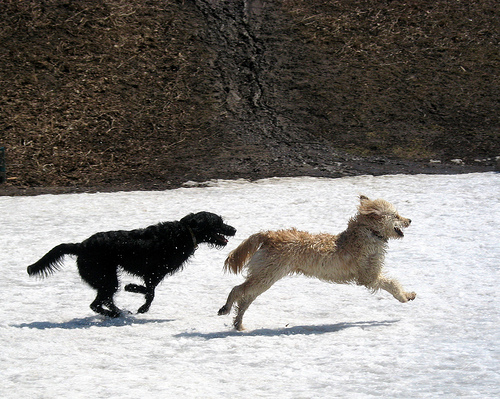

In [53]:
for img_path, caps in train_raw.take(1):
    break
print(img_path)
img = load_img(img_path)
print(img.shape)
caps = [cap.numpy().decode('utf-8') for cap in caps]
print(caps)
Image.open(img_path.numpy().decode('utf-8'))

In [54]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self, img = img):
        self.image = img[tf.newaxis, ...]
        self.caps = caps

    def on_epoch_end(self, epochs = None, logs = None):
        print('\n')
        for temp in (0, 0.5, 1):
            gen_text = self.model.generate_text(self.image)
            f_val = self.model.f_score(gen_text, self.caps, n_gram_range = 1)
            print(f'Generated_text: {gen_text}, \t f_score: {f_val}')

In [56]:
learning_rate_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=3e-4,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.9,
    alpha=0.1
)

In [57]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate_scheduler,
    weight_decay=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)
callbacks = [GenerateText(),
             tf.keras.callbacks.EarlyStopping(patience = 6, restore_best_weights = True)]

In [58]:
captioner_model.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])


In [59]:
hist = captioner_model.fit(
    train_ds.repeat(),
    steps_per_epoch = 100,
    validation_data = test_ds.repeat(),
    validation_steps = 10,
    epochs = 20,
    callbacks = callbacks
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_14' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 4.6552 - masked_accuracy: 0.2475



/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Generated_text: a black dog is running through a ball, 	 f_score: 0
Generated_text: a black dog is running off the grass, 	 f_score: 0.305863673439423
Generated_text: a dog in the air, 	 f_score: 0.16886511879816196
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 377ms/step - loss: 4.6520 - masked_accuracy: 0.2479 - val_loss: 3.8670 - val_masked_accuracy: 0.3315
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 3.8227 - masked_accuracy: 0.3460

Generated_text: a dog is running in the snow, 	 f_score: 0.34675115990007266
Generated_text: a black dog jumps in a black and white dog, 	 f_score: 0
Generated_text: two dogs a dog, 	 f_score: 0.08588482777109359
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 399ms/step - loss: 3.8217 - masked_accuracy: 0.3461 - val_loss: 3.5621 - val_masked_accuracy: 0.3574
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 3.5034 - masked_accuracy: 0.3712

Generated_text: two dogs run in the air in the snow, 	 f_score: 0.47058823529411764
Generated_text: a dog is ju

Validation

In [60]:
BASE_DIR = "/content/flickr8k"
CAP_TEXT_PATH = os.path.join(BASE_DIR, "Flickr8k_text.zip/Flickr8k.token.txt")
TRAIN_TXT_PATH = os.path.join(BASE_DIR, "Flickr8k_text.zip/Flickr_8k.trainImages.txt")
TEST_TXT_PATH = os.path.join(BASE_DIR, "Flickr8k_text.zip/Flickr_8k.testImages.txt")
VAL_TXT_PATH = os.path.join(BASE_DIR, "Flickr8k_text.zip/Flickr_8k.devImages.txt")
TXT_PATH = os.path.join(BASE_DIR, "Flickr8k_text.zip/Flickr_8k.trainImages.txt")
print("Paths updated for Google Colab!")

Paths updated for Google Colab!


In [61]:
def clean_cap(caption: str) -> str:
    cap = ''.join([ch for ch in caption if ch not in string.punctuation])
    cap = cap.split()
    cap = [word.casefold() for word in cap]
    cap = [word for word in cap if len(word) > 1]
    cap = [word for word in cap if word.isalpha()]
    lemmatizer = nltk.WordNetLemmatizer()
    cap = [lemmatizer.lemmatize(word) for word in cap]
    return ' '.join(cap)

In [62]:
def load_cap(caption_txt_path: str) -> dict:
    with open(caption_txt_path, 'r', encoding='utf-8') as caption_txt:
        captions_list = caption_txt.readlines()
    mapping = dict()
    for line in captions_list:
        caption = line.split('\t')
        image_name = caption[0][:-2].split('.')[0]
        image_caption = clean_cap(caption[-1][:-1])
        image_caption = 'startofseq ' + image_caption + ' endofseq'
        if image_name in mapping:
            mapping[image_name].append(image_caption)
        else:
            mapping[image_name] = [image_caption]
    return mapping

In [63]:
def save_captions(mapping: dict, filename: str) -> bool:
    lines = [key + ' ' + cap for key, cap_list in mapping.items() for cap in cap_list]
    with open(filename, 'w') as file:
        file.write('\n'.join(lines))
    return True

In [64]:
def load_doc(filename: str) -> str:
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

In [65]:
def load_set(text_file_path: str) -> set:
    doc = load_doc(text_file_path)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [66]:
def load_clean_cap(caption_txt_path: str, dataset: set) -> dict:
    doc = load_doc(caption_txt_path)
    clean_captions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_name, image_cap = tokens[0], " ".join(tokens[1:])
        if image_name in dataset:
            if image_name not in clean_captions:
                clean_captions[image_name] = list()
            clean_captions[image_name].append(image_cap)
    return clean_captions

In [67]:
def max_len(clean_captions: dict) -> int:
    clean_captions_list = [caption.split() for captions in clean_captions.values()
                           for caption in captions]
    return max(len(caption) for caption in clean_captions_list)

In [68]:
CAP_TEXT_PATH

'/content/flickr8k/Flickr8k_text.zip/Flickr8k.token.txt'

In [69]:
CLEAN_CAP_TEXT_PATH = "/content/flickr8k/Flickr8k_clean_cap.txt"

In [70]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [71]:
import string

In [72]:
cap_dict = load_cap(CAP_TEXT_PATH)

In [73]:
save_captions(cap_dict,CLEAN_CAP_TEXT_PATH)

True

In [74]:
VAL_TXT_PATH = "/content//Flickr_8k.devImages.txt"

In [75]:
val_img_names = sorted(load_set(TEST_TXT_PATH))

In [76]:
val_img_cap = load_clean_cap(CLEAN_CAP_TEXT_PATH, val_img_names)

In [77]:
len(val_img_cap)

1000

In [78]:
IMG_FILE_PATH = "/content/flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/"

In [79]:
def img_name_2_path(image_name: str, img_file_path: str = IMG_FILE_PATH, ext: str = r".jpg") -> str:
    image_path = img_file_path + str(image_name) + ext
    return image_path

In [143]:
image_name = val_img_names[np.random.randint(0, len(val_img_names))]
img_path = img_name_2_path(image_name)
real_captions = val_img_cap[image_name]

In [144]:
image_name

'96420612_feb18fc6c6'

In [145]:
img_path

'/content/flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/96420612_feb18fc6c6.jpg'

In [146]:
real_captions

['startofseq man in red swim trunk is jumping onto bodyboard endofseq',
 'startofseq man in red trunk fly through the air with boogie board endofseq',
 'startofseq man with wakeboard is diving over surface that is not water endofseq',
 'startofseq shirtless man bodysurfs endofseq',
 'startofseq man is diving onto his wakeboard endofseq']

In [148]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import glob

def predict_caption_from_path(image_path, model, temperature=0.5):
    img = load_img(image_path)
    caption = model.generate_text(img[tf.newaxis, ...], temperature=temperature)
    return caption

def display_image_with_caption(image_path, caption):
    image = Image.open(image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.title(f"Generated caption: {caption}", fontsize=12)
    plt.tight_layout()
    plt.show()

def predict_random_image(folder_path, model, num_images=1, temperature=0.5):
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.gif']:
        image_files.extend(glob.glob(os.path.join(folder_path, ext)))

    if not image_files:
        print(f"No image files found in {folder_path}")
        return
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    for img_path in selected_images:
        try:
            caption = predict_caption_from_path(img_path, model, temperature)
            display_image_with_caption(img_path, caption)
            print(f"Image: {os.path.basename(img_path)}")
            print(f"Caption: {caption}")
            print("-" * 50)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")


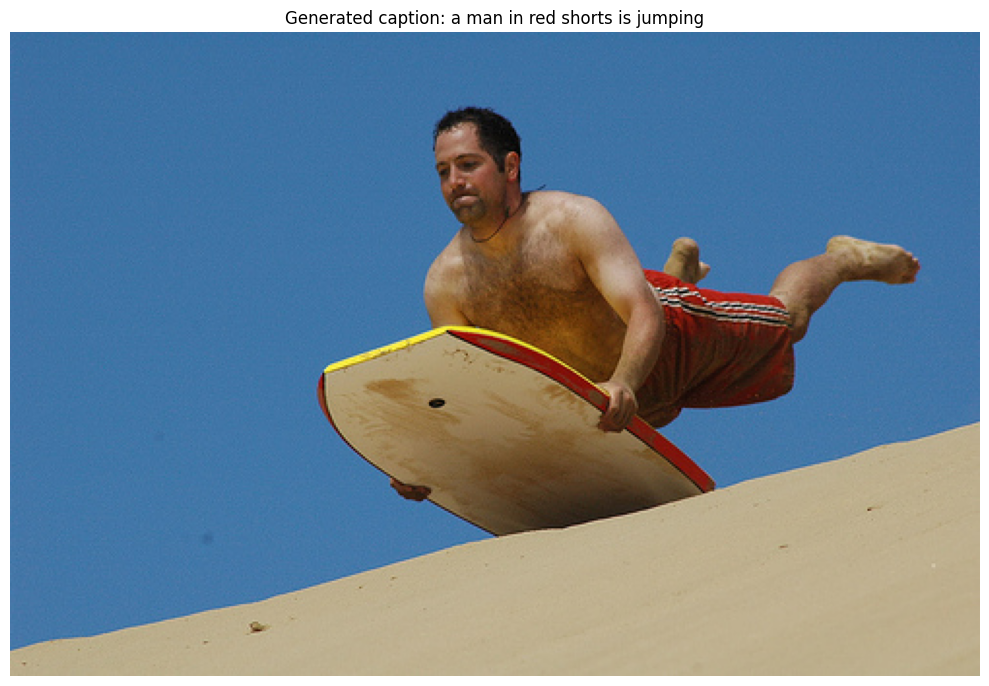

In [149]:
caption = predict_caption_from_path(img_path, captioner_model)
display_image_with_caption(img_path, caption)

In [150]:
print(caption)
print('Real Captions:')
for i, cap in enumerate(real_captions):
    print(f"{i+1}) {cap[10:-8]}")

a man in red shorts is jumping
Real Captions:
1)  man in red swim trunk is jumping onto bodyboard 
2)  man in red trunk fly through the air with boogie board 
3)  man with wakeboard is diving over surface that is not water 
4)  shirtless man bodysurfs 
5)  man is diving onto his wakeboard 


In [151]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

nltk.download('wordnet')
nltk.download('omw-1.4')

def calculate_metrics(pred_caption, real_captions):

    pred_tokens = pred_caption.split()
    real_tokens = [caption.split() for caption in real_captions]
    smoothie = SmoothingFunction().method1
    bleu_1 = sentence_bleu(real_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)  # BLEU-1
    bleu_2 = sentence_bleu(real_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)  # BLEU-2
    bleu_3 = sentence_bleu(real_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)  # BLEU-3
    bleu_4 = sentence_bleu(real_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)  # BLEU-4

    # ROUGE Score Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(pred_caption, cap) for cap in real_captions]
    avg_rouge = {
        "rouge1": sum([s['rouge1'].fmeasure for s in rouge_scores]) / len(rouge_scores),
        "rouge2": sum([s['rouge2'].fmeasure for s in rouge_scores]) / len(rouge_scores),
        "rougeL": sum([s['rougeL'].fmeasure for s in rouge_scores]) / len(rouge_scores),
    }

    # METEOR Score Calculation (Fixed)
    meteor_scores = [meteor_score([cap.split()], pred_tokens) for cap in real_captions]  # Pass tokenized captions
    avg_meteor = sum(meteor_scores) / len(meteor_scores)

    return {
        "BLEU-1": bleu_1,
        "BLEU-2": bleu_2,
        "BLEU-3": bleu_3,
        "BLEU-4": bleu_4,
        "ROUGE-1": avg_rouge["rouge1"],
        "ROUGE-2": avg_rouge["rouge2"],
        "ROUGE-L": avg_rouge["rougeL"],
        "METEOR": avg_meteor
    }

predicted_caption = caption
metrics = calculate_metrics(predicted_caption, real_captions)

print("\nEvaluation Scores:")
for metric, score in metrics.items():
    print(f"{metric}: {score:.4f}")



Evaluation Scores:
BLEU-1: 0.6192
BLEU-2: 0.5181
BLEU-3: 0.3629
BLEU-4: 0.1782
ROUGE-1: 0.2978
ROUGE-2: 0.1194
ROUGE-L: 0.2978
METEOR: 0.1995


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
